In [ ]:
!pip install kaggle
!pip install wandb

In [2]:
!mkdir /root/.kaggle

In [3]:
!mv /content/kaggle.json /root/.kaggle

In [4]:
!ls -a /root/.kaggle

.  ..  kaggle.json


In [5]:
!kaggle datasets download -d jangedoo/utkface-new

 95% 314M/331M [00:02<00:00, 152MB/s]
100% 331M/331M [00:02<00:00, 134MB/s]


In [ ]:
!unzip /content/utkface-new.zip 

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import wandb
from wandb.keras import WandbCallback

In [ ]:
wandb.init(project='Age Estimation')

In [3]:
width = height = 175
batchSize = 32

In [4]:
images = [] # X
ages = [] # Y

for image_name in os.listdir("/content/UTKFace"):
    ages.append(int(image_name.split('_')[0]))

    image = cv2.imread(f"/content/UTKFace/{image_name}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (width, height))
    images.append(image)


In [5]:
images = pd.Series(images, name='Images')
ages = pd.Series(ages, name='Ages')

dataframe = pd.concat([images, ages], axis=1)
dataframe.head()

,Images,Ages
0,"[[[247, 245, 248], [245, 243, 246], [243, 241,...",26
1,"[[[75, 68, 75], [66, 59, 66], [60, 54, 58], [5...",60
2,"[[[12, 2, 10], [14, 4, 12], [16, 6, 14], [14, ...",5
3,"[[[246, 246, 246], [234, 234, 234], [219, 219,...",7
4,"[[[37, 52, 49], [38, 53, 50], [37, 53, 50], [3...",30


26


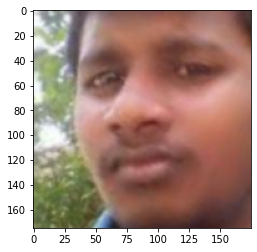

In [6]:
print(dataframe["Ages"][0])
plt.imshow(dataframe["Images"][0])
plt.show()

60


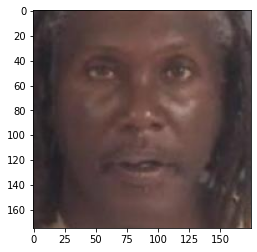

In [7]:
print(dataframe["Ages"][1])
plt.imshow(dataframe["Images"][1])
plt.show()

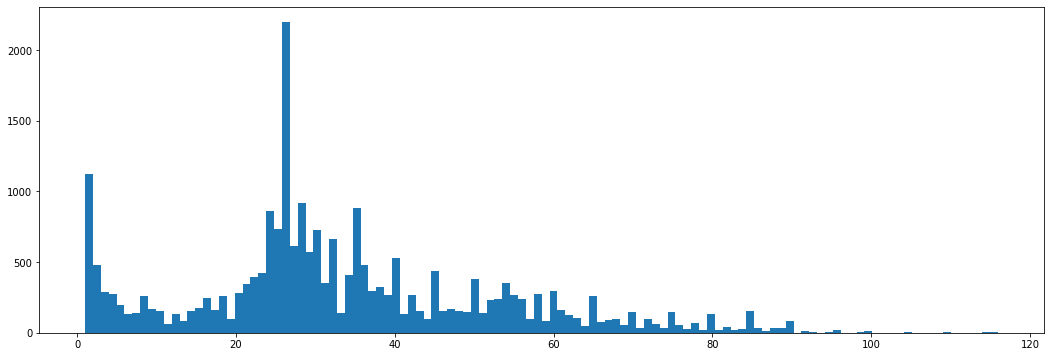

In [8]:
plt.figure(figsize=(18, 6))
plt.hist(dataframe["Ages"], bins=dataframe["Ages"].max())
plt.show()

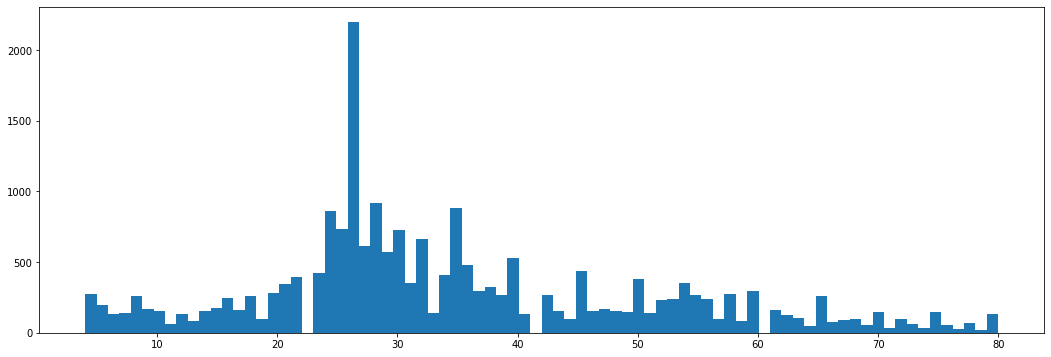

In [9]:
dataframe = dataframe[dataframe["Ages"] <= 80]
dataframe = dataframe[dataframe["Ages"] >= 4]

plt.figure(figsize=(18, 6))
plt.hist(dataframe["Ages"], bins=dataframe["Ages"].max())
plt.show()

In [10]:
# # دو سوم بچه های زیر 4 سال رو دور بریزیم

# under_4 = dataframe[dataframe["Ages"] <= 4]
# under_4_new = under_4.sample(frac=0.3)

# up_4 = dataframe[dataframe["Ages"] > 4]

# dataframe = pd.concat([under_4_new, up_4], axis=0)

In [11]:
# plt.figure(figsize=(18, 6))
# plt.hist(dataframe["Ages"], bins=dataframe["Ages"].max())
# plt.show()

In [12]:
# between_20_30 = dataframe[(dataframe["Ages"] <= 30) & (dataframe["Ages"] >= 20)]
# between_20_30_new = between_20_30.sample(frac=0.4)

# other = dataframe[(dataframe["Ages"] > 30) | (dataframe["Ages"] < 20)]

# dataframe = pd.concat([between_20_30_new, other], axis=0)

# plt.figure(figsize=(18, 6))
# plt.hist(dataframe["Ages"], bins=dataframe["Ages"].max())
# plt.show()

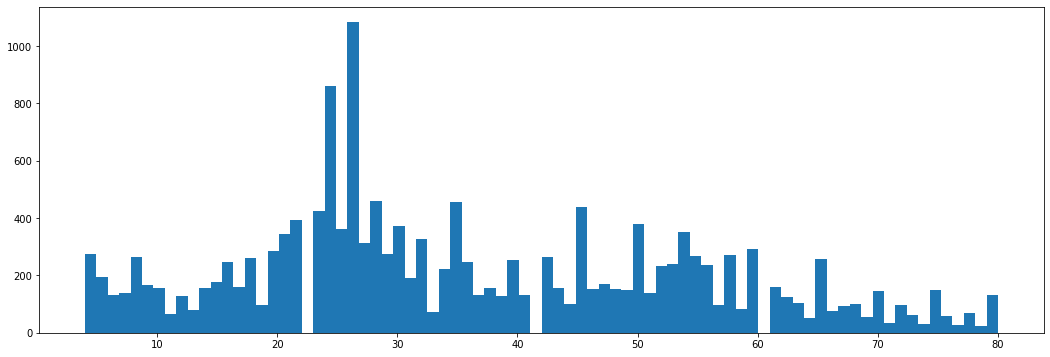

In [13]:
between_25_40 = dataframe[(dataframe["Ages"] <= 40) & (dataframe["Ages"] >= 25)]
between_25_40_new = between_25_40.sample(frac=0.5)
other = dataframe[(dataframe["Ages"] > 40) | (dataframe["Ages"] < 25)]
dataframe = pd.concat([between_25_40_new, other], axis=0)

plt.figure(figsize=(18, 6))
plt.hist(dataframe["Ages"], bins=dataframe["Ages"].max())
plt.show()

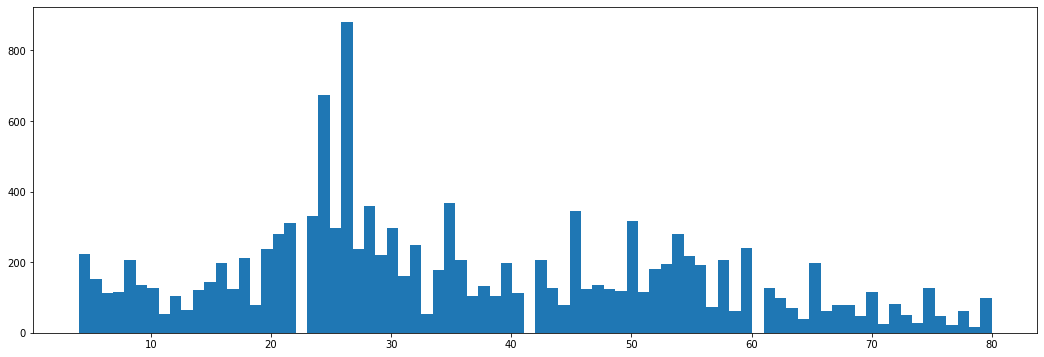

In [14]:
dataframe = dataframe.sample(frac=0.8)

plt.figure(figsize=(18, 6))
plt.hist(dataframe["Ages"], bins=dataframe["Ages"].max())
plt.show()

In [15]:
X = np.array(dataframe["Images"].values.tolist())
Y = np.array(dataframe["Ages"].values.tolist())

In [16]:
print(X.shape, Y.shape)

(12980, 175, 175, 3) (12980,)


In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

In [18]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(10384, 175, 175, 3)
(2596, 175, 175, 3)
(10384,)
(2596,)


In [19]:
idg = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2)
)

In [20]:
train_data = idg.flow(X_train, Y_train, batch_size=batchSize)

val_data = idg.flow(X_val, Y_val, batch_size=batchSize)

In [21]:
base_model = tf.keras.applications.ResNet50V2(
    input_shape = (width, height, 3),
    weights="imagenet",
    include_top=False,
    pooling='avg'
)

In [22]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [23]:
model = tf.keras.models.Sequential([
        base_model,
        Dropout(0.3),
        Dense(1, activation='linear')
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 6,145
Non-trainable params: 23,560,704
_________________________________________________________________


In [25]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=tf.keras.losses.mse)

In [26]:
model.fit(train_data,
          validation_data=val_data,
          epochs=35,
          shuffle=True,
          callbacks=[WandbCallback()])

Epoch 1/35
325/325 [==============================] - 77s 191ms/step - loss: 235.0448 - val_loss: 158.5542 - _timestamp: 1648910077.0000 - _runtime: 137.0000
Epoch 2/35
325/325 [==============================] - 58s 177ms/step - loss: 162.4521 - val_loss: 142.3535 - _timestamp: 1648910135.0000 - _runtime: 195.0000
Epoch 3/35
325/325 [==============================] - 57s 177ms/step - loss: 158.7713 - val_loss: 133.4874 - _timestamp: 1648910193.0000 - _runtime: 253.0000
Epoch 4/35
325/325 [==============================] - 57s 176ms/step - loss: 158.7562 - val_loss: 132.9613 - _timestamp: 1648910250.0000 - _runtime: 310.0000
Epoch 5/35
325/325 [==============================] - 57s 175ms/step - loss: 151.7890 - val_loss: 141.0594 - _timestamp: 1648910308.0000 - _runtime: 368.0000
Epoch 6/35
325/325 [==============================] - 57s 174ms/step - loss: 158.8498 - val_loss: 133.1095 - _timestamp: 1648910364.0000 - _runtime: 424.0000
Epoch 7/35
325/325 [==============================] 

In [ ]:
image = cv2.imread('')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (width, height))
image = image / 255
image = image[np.newaxis, ...]

result = model.predict(image)
print(result)